In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst.traces import philly
from skyburst.traces import philly_utils

In [2]:
jobs = philly.load_philly_traces('~/philly-traces/trace-data')
jobs.sort(key=lambda j: j._submitted_time)
all_jobs = jobs

In [3]:
from math import floor, ceil

# Maximum job time in hours
CLIP_MAX_TIME = 1e9

# Deadline Multiplier d_t = a_t + K * r_t
DEADLINE_CONSTANT = 1.25

# Returns the deadline of a job.
# For continuous simulator
def deadline_mult_fn(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT):
    waiting_time = (deadline_mult - 1)*run_time
    waiting_time = max(1/12.0, waiting_time)
    return arrival_time + waiting_time + run_time

def deadline_ljw(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT, run_thres=8.0):
    if run_time < run_thres:
        return arrival_time + run_time
    waiting_time = (deadline_mult - 1)*run_time
    return arrival_time + waiting_time + run_time

def deadline_infinite_fn(arrival_time, run_time):
    return 1e12

def deadline_zero_fn(arrival_time, run_time):
    return arrival_time + run_time

# Returns the total cost of a job.
def gpu_cost_fn(resources: dict, run_time: float):
    return resources['GPUs'] * run_time

def time_thres_fn(job, run_thres):
    return job.runtime >= run_thres

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

# Num nodes
NUM_NODES = 16

def preprocess_jobs(jobs: List['JobTrace'], deadline_fn= deadline_infinite_fn , cost_fn=gpu_cost_fn, clip_time: float = CLIP_MAX_TIME):
    """Converts a list of jobs into (arrival_time, run_time, deadline, resources, cost).
    """
    jobs = jobs.copy()
    # Remove invalid jobs (jobs that have not finished and jobs that failed/killed early)
    jobs = [j for j in jobs if j._run_time is not None and j.status=='Pass']
    jobs.sort(key=lambda j: j._submitted_time)
    
    if not clip_time:
        clip_time = 1e9
    
    # Arrival time for jobs
    start_time = jobs[0]._submitted_time
    arrival_times = [(j._submitted_time- start_time).total_seconds()/3600.0 for j in jobs]
    
    # Run time for jobs
    run_times = []
    for j in jobs:
        # Clip the maximum run time for jobs to simplify simulation.
        run_time_hr = j._run_time/60.0
        if run_time_hr > clip_time:
            run_times.append(clip_time)
        else:
            run_times.append(run_time_hr)
    
    deadlines = [deadline_fn(arrival, run) for arrival, run in zip(arrival_times, run_times)]
    
    # Get GPU resources
    resources = []
    for j in jobs:
        detail_dict = j.attempts[-1]['detail']
        gpu_count = sum([len(node_dict['gpus']) for node_dict in detail_dict])
        resources.append({'GPUs': gpu_count})
    
    costs = [cost_fn(res, run) for res, run in zip(resources, run_times)]
    
    return [Job(idx, arr, run, dead, res, cost) \
            for idx, (arr, run, dead, res, cost) in \
            enumerate(list(zip(arrival_times, run_times, deadlines, resources, costs)))]

In [4]:
class Node(object):
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.gpu_dict = {}
        for idx in range(self.num_gpus):
            self.gpu_dict[idx] = None
    
    def free_gpus(self):
        return len([v for v in self.gpu_dict.values() if not isinstance(v, Job)])
    
    def try_fit(self, cur_timestamp, job, num_gpus=None):
        gpu_list = []
        if num_gpus==None:
            num_gpus = job.resources['GPUs']

        if num_gpus > self.free_gpus():
            return False, gpu_list

        counter =0
        for idx in range(self.num_gpus):
            gpu_val = self.gpu_dict[idx]
            if not isinstance(gpu_val, Job):
                self.gpu_dict[idx] = job
                gpu_list.append(idx)
                counter +=1
            if counter >= num_gpus:
                break
        return True, gpu_list
    
    def __repr__(self):
        return f'{self.gpu_dict}'        
        

class Cluster(object):
    
    def __init__(self, num_nodes, num_gpus_per_node, preempt=None, reserve=False):
        self.num_nodes = num_nodes
        self.num_gpus_per_node = num_gpus_per_node
        self.nodes = [Node(num_gpus_per_node) for _ in range(num_nodes)]
        self.preempt = preempt
        self.reserve = reserve
        self.active_jobs = {}
    
    def is_full(self):
        for n in self.nodes:
            for gpu_idx in n.gpu_dict:
                if not n.gpu_dict[gpu_idx]:
                    return False
        return True
    
    def try_fit_v2(self, cur_timestamp, job):
        num_gpus = job.resources['GPUs']
                        
        # Generate Plan
        free_gpus = [n.free_gpus() for n in self.nodes]
        free_plus_preempted_gpus = free_gpus.copy()
        node_idx_to_pre_job = {}
        
        # Logic to pre-empt GPU(s). Generates candidates jobs to be pre-empted on the cluster.
        preemptible_jobs = []
        if self.preempt:
            C = 1.0/self.preempt - 1.0
            for j_idx, j in self.active_jobs.items():
                # Filter for jobs that will not exceed deadline (if preempted)
                if j.deadline - j.runtime > cur_timestamp and job.runtime > j.runtime:
                    # job.cost - j.cost >= j.opp_cost:
                    factor = 0
                    if j.num_gpus > job.num_gpus:
                        factor = (1 - (job.num_gpus/j.num_gpus))*job.runtime
                    if j.num_gpus ==0:
                        continue
                    if job.runtime - j.runtime >= C * (cur_timestamp - j.start) + factor + j.opp_cost/(self.preempt*j.num_gpus):
                        preemptible_jobs.append(j)                  
            preemptible_jobs.sort(key=lambda x: x.cost)
        
        # No hope of fitting onto cluster :(
        if num_gpus > sum(free_plus_preempted_gpus):
            return False, []
        
        # Generate job GPU demands
        if num_gpus > self.num_gpus_per_node:
            # Multinode case, i.e. 26 GPUs, 8 GPU/node cluster -> job_gpu_demands = [8,8,8,2]
            job_gpu_demands = [self.num_gpus_per_node]*int(num_gpus/self.num_gpus_per_node)
            if num_gpus%self.num_gpus_per_node:
                job_gpu_demands.append(num_gpus%self.num_gpus_per_node)
        else:
            job_gpu_demands = [num_gpus]

        # Generate Plans - which nodes to place job on and which jobs to preempt
        # Maps node idx to gpu_demand
        node_idx_taken = {}
        # Maps node idx to (gpu_demand, list of job idx of preempted jobs on that node)
        preempted_idx_taken = {}
        remove_idx = []
        
        # Go through free space only first, generate partial plan with free space
        for list_idx, gpu_demand in enumerate(list(job_gpu_demands)):
            for n_idx, n in enumerate(self.nodes):
                if n_idx in node_idx_taken:
                    continue
                if free_gpus[n_idx] >= gpu_demand:
                    node_idx_taken[n_idx] = gpu_demand
                    job_gpu_demands.remove(gpu_demand)
                    break

        # Go through premptible jobs to find more space, generate final plan
        if self.preempt and job_gpu_demands:
            temp_free_gpus = free_gpus.copy()
            preemptible_jobs_to_node = [[] for _ in range(self.num_nodes)]
            for pre_j in preemptible_jobs:
                for n_idx, n_gpu_list in pre_j.allocated_gpus.items():
                    temp_free_gpus[n_idx] += len(n_gpu_list)
                    preemptible_jobs_to_node[n_idx].append(pre_j)
                
                for list_idx, gpu_demand in enumerate(list(job_gpu_demands)):
                    for n_idx, n in enumerate(self.nodes):
                        if n_idx in node_idx_taken or n_idx in preempted_idx_taken:
                            continue
                        if temp_free_gpus[n_idx] >= gpu_demand:
                            preempted_idx_taken[n_idx] = (gpu_demand, [j.idx for j in preemptible_jobs_to_node[n_idx]]) 
                            job_gpu_demands.remove(gpu_demand)
                            break
                
                if not job_gpu_demands:
                    break
            
        # If there are still demands that cannot be satisifed via free and preempted jobs,
        # it cannot be scheduled on the cluster.
        if job_gpu_demands:
            return False, []
        
        # Execute plan
        preempted_jobs = []
        # Populate nodes that enough free gpus
        for n_idx, gpu_demand in node_idx_taken.items():
            gpu_list = self.try_fit_node(self.nodes[n_idx], cur_timestamp, job, num_gpus=gpu_demand)
            job.allocated_gpus[n_idx] = gpu_list
        
        if self.preempt:
            # Poppulate nodes that need jobs preempted first
            buffer = []
            for n_idx, job_tuple in preempted_idx_taken.items():
                gpu_demand, preempted_job_idxs = job_tuple
                for job_idx in preempted_job_idxs:
                    if job_idx in buffer:
                        continue
                    pre_job = self.active_jobs[job_idx]
                    job.opp_cost += (cur_timestamp - pre_job.start) * pre_job.num_gpus
                    preempted_job = self.preempt_job(job_idx)
                    preempted_jobs.append(preempted_job)
                    buffer.append(job_idx)
                gpu_list = self.try_fit_node(self.nodes[n_idx], cur_timestamp, job, num_gpus=gpu_demand)
                job.allocated_gpus[n_idx] = gpu_list
        
        job.start = cur_timestamp
        self.active_jobs[job.idx] = job
        
        return True, preempted_jobs
    
    def try_fit_node(self, node, cur_timestamp, job, num_gpus=None):
        gpu_list = []
        if num_gpus==None:
            num_gpus = job.resources['GPUs']

        if num_gpus > node.free_gpus():
            raise ValueError("Should not go here in try_fit_node!")

        counter =0
        for idx in range(node.num_gpus):
            gpu_val = node.gpu_dict[idx]
            if not isinstance(gpu_val, Job):
                node.gpu_dict[idx] = job
                gpu_list.append(idx)
                counter +=1
            if counter >= num_gpus:
                break
        return gpu_list
    
    def preempt_job(self, job_idx):
        assert job_idx in self.active_jobs
        r_job = self.active_jobs[job_idx]
        for n_idx, gpu_list in r_job.allocated_gpus.items():
            node = self.nodes[n_idx]
            for gpu_idx in gpu_list:
                node.gpu_dict[gpu_idx] = None
        r_job.start = None
        r_job.allocated_gpus = {}
        del self.active_jobs[job_idx]
        return r_job
            
    def try_clear(self, t: float):
        """Clears cluster of completed jobs.
        """
        completed_jobs = []
        for job_idx, job in self.active_jobs.items():
            if t >= job.start + job.runtime:
                node_gpu_dict = job.allocated_gpus
                for node_idx, gpu_list in node_gpu_dict.items():
                    node_gpu_dict = self.nodes[node_idx].gpu_dict
                    for gpu_idx in gpu_list:
                        node_gpu_dict[gpu_idx] = None
                completed_jobs.append(job)
        
        for job in completed_jobs:
            job.state = 'LOCAL'
            del self.active_jobs[job.idx]
        return completed_jobs
    
    def __repr__(self):
        repr_str = 'Cluster State:\n'
        for idx, n in enumerate(self.nodes):
            repr_str += f'Node {idx}: {n}\n'
        return repr_str



In [5]:
## Attempt Pre-emption
# Add job into the cluster -> pre empt jobs (what jobs to preempt?)
# Only preempt jobs that have reached deadline & are cheaper than the current job
# Preempted jobs go back into the queue
# Warning very slow!
def continuous_simulator(jobs: List[Job], policy, num_nodes, job_filter_policy=None, preempt=None, asdf=False, reserve=False, verbose=False, debug=False):
    if policy=='fifo':
        sort_func = lambda x: x.arrival
    elif policy == 'edf':
        sort_func = lambda x: x.deadline
    elif policy == 'sjf':
        sort_func = lambda x: x.runtime
    elif policy == 'svjf':
        sort_func = lambda x: x.cost
    elif policy == 'ljf':
        sort_func = lambda x: -x.runtime
    elif policy == 'lvjf':
        sort_func = lambda x: -x.cost
    elif policy == 'lcf':
        sort_func = lambda x: x.num_gpus
    else:
        raise ValueError(f'Policy {policy} does not match!')
    
    job_filter_fn = None
    if job_filter_policy is not None:
        job_filter_policy, run_thres = job_filter_policy.split('-')
        if job_filter_policy == 'ljw':
            job_filter_fn = lambda x: time_thres_fn(x, float(run_thres))
        else:
            raise ValueError(f'Incorrect job filter policy {job_filter_policy}.')
    finished_jobs = []
    jobs = copy.deepcopy(jobs)
    num_jobs = len(jobs)

    queue = []
    cloud_cost = 0
    cluster = Cluster(num_nodes=num_nodes, num_gpus_per_node=GPUS_PER_NODE, preempt=preempt, reserve=reserve)
    t=0
    snapshots = {}
    while len(jobs) >0 or len(queue)>0:
        # Clear cluster of jobs that have completed
        finished_jobs.extend(cluster.try_clear(t))
        
        # Check for jobs that have waited too long (move to cloud).
        for job in queue[:]:
            if t >= job.deadline - job.runtime:
                queue.remove(job)
                job.state = 'TIMEOUT-CLOUD'
                finished_jobs.append(job)
                cloud_cost += job.cost
        
        # Add jobs to queue that have arrived
        for job in jobs[:]:
            if job.arrival < t:
                raise ValueError("Should not have entered here!")
                
            if job.arrival == t:
                jobs.remove(job)
                if job_filter_fn is not None:
                    # If arrival job does not satisfy job filter, move job to cloud.
                    if not job_filter_fn(job):
                        job.state = 'FILTER-CLOUD'
                        finished_jobs.append(job)
                        cloud_cost += job.cost
                        continue
                queue.append(job)
            else:
                break
            
                
        # Sort queue based on heuristic
        queue.sort(key = sort_func)
        
        # Go through queue and fit jobs onto cluster as needed
        preempted_jobs = []
        for job in queue[:]:
            can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
            if can_fit:
                queue.remove(job)
                queue.extend(preempted_jobs)
            elif not asdf:
                break
        
        snapshots[t] = copy.deepcopy(queue)
        
        next_time_list = []
        # Skip to next timestep where a new job either arrives or when a job finishes on the cluster.
        for job_idx, job in cluster.active_jobs.items():
            release_time = job.start + job.runtime
            next_time_list.append(release_time)

        if len(jobs)>0:
            next_time_list.append(jobs[0].arrival)
        
        if len(next_time_list)==0:
            assert len(queue)==0 and len(jobs) ==0
            break
        
        if min(next_time_list) < t:
            raise ValueError('Simulator is severely bugged; Raise a Git Issue.')
                
        if verbose or debug:
            print(f'Timestamp: {t}')
            print(f'Jobs left: {len(jobs)}')
            print(f'Cloud Cost: {cloud_cost}')
            print(cluster)
            print('Queue: ' + str(queue) + '\n')
            print('Finished Jobs: ' + str(finished_jobs) + '\n')
            if debug:
                import pdb; pdb.set_trace()
        
        t = min(next_time_list)
    finished_jobs.extend(cluster.try_clear(1e12))
    
    # Compute Avg. Waiting Time
    total_waiting_time = 0.0
    for job in finished_jobs:
        # Moved to cloud
        if job.start is None:
            if job.state == 'TIMEOUT-CLOUD':
                total_waiting_time += job.deadline - job.runtime - job.arrival
            elif job.state == 'FILTER-CLOUD':
                pass
            else:
                raise ValueError('Invalid State!')
        else:
            assert job.state == 'LOCAL'
            total_waiting_time += job.start - job.arrival

    print(f'{policy}-{num_nodes}')
    print(f'Cloud Cost ({policy}-{num_nodes}): {cloud_cost}')
    print(f'Avg Waiting Time ({policy}-{num_nodes}): {total_waiting_time/len(finished_jobs)}')
    print(len(finished_jobs))
    return f'{policy}-{num_nodes}', finished_jobs, snapshots

In [6]:
temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=1.5)
jobs_proc = preprocess_jobs(jobs, deadline_fn=temp_fn)

asdf = continuous_simulator(jobs_proc, 'swf', 72)

asdf1 = continuous_simulator(jobs_proc, 'swf', 72, asdf=True)#job_filter_policy='ljw-1')

ValueError: Policy swf does not match!

In [1]:
def plot_trace_spacetime(jobs, num_nodes, snapshots):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs) + 5
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)]
    jobs.sort(key=lambda x: x.idx)
    fig, ax = plt.subplots(figsize=(100, 50))
    total_gpus = num_nodes * GPUS_PER_NODE
    
    lol = []
    for j in jobs:
        if j.start is not None:
            lol.append(j.start + j.runtime)
    max_time = max(lol)
    gpu_id_to_segments = {}
    
    for j_idx, job in enumerate(jobs):
        allocated_gpus = job.allocated_gpus
        if not allocated_gpus:
            continue
        for node_idx in allocated_gpus.keys():
            for node_gpu_idx in allocated_gpus[node_idx]:
                gpu_idx = total_gpus - (GPUS_PER_NODE * node_idx +
                                        node_gpu_idx)
                if gpu_idx not in gpu_id_to_segments:
                    gpu_id_to_segments[gpu_idx] = []
                
                gpu_id_to_segments[gpu_idx].append((job.start, job.start+job.runtime))
                
    total_wasted_space = 0.0
    online_wasted_space = 0.0           
    gpu_id_to_antisegments = {}
    time_to_antisegments = {}
    for idx, segments in gpu_id_to_segments.items():
        start_time =0
        cur_segment = (0, 0)
        for seg_idx in range(len(segments)):
            next_segment = segments[seg_idx]
            if idx not in gpu_id_to_antisegments:
                gpu_id_to_antisegments[idx] = []
            if cur_segment[1] == next_segment[0]:
                cur_segment = next_segment
                continue
            antisegment = (cur_segment[1], next_segment[0])
            antisegment_width = antisegment[1]-antisegment[0]
            gpu_id_to_antisegments[idx].append(antisegment)
            if cur_segment[1] not in time_to_antisegments:
                time_to_antisegments[cur_segment[1]] = []
            time_to_antisegments[cur_segment[1]].append((idx-1, antisegment_width))
            total_wasted_space += antisegment_width
            cur_segment = next_segment
        
        if cur_segment[1] < max_time:
            new_segment = (cur_segment[1], max_time)
            gpu_id_to_antisegments[idx].append(new_segment)
            new_segment_width = max_time - cur_segment[1]
            total_wasted_space += new_segment_width
            if cur_segment[1] not in time_to_antisegments:
                time_to_antisegments[cur_segment[1]] = []
            time_to_antisegments[cur_segment[1]].append((idx-1, new_segment_width))
    
    asdf = []
    for time, tuples in time_to_antisegments.items():
        queue_time = snapshots[time]
        num_empty_gpus = len(tuples)
        node_idx = [t[0]/8 for t in tuples]
        lol = {}
        for n in node_idx:
            if n not in lol:
                lol[n] = 0
            lol[n] +=1
        num_gpu_per_node = list(lol.values())
        num_gpu_per_node.sort(reverse=True)
        
        can_fit = [False]*len(queue_time)
        for idx, q_job in enumerate(queue_time):
            q_gpus = q_job.num_gpus
            if q_gpus > 8:
                
        
        if len(queue_time)>0:
            if queue_time[0].num_gpus > num_empty_gpus:
                # Reason: Head of the line blocking, CAN stuff gpus in with jobs later in queue
                import pdb; pdb.set_trace()
                if not any([q.num_gpus>num_empty_gpus for q in queue_time[1:]]):
                    color = 'blue'
                else:
                    color = 'green'
            else:
                color = 'red'
            asdf.append((num_empty_gpus, sum([j.num_gpus for j in queue_time])))
        else:
            # Queue is empty
            color = 'black'
        
        for gpu_idx, width in tuples:
            ax.barh(gpu_idx+1,
                width=width,
                #edgecolor='black',
                height=1.0,
                left=time,
                align='edge',
                color=color)
#         for gpu_idx, segment_width in tuples:
#             if len(queue) == 0:
#                 online_wasted_space += antisegment_width
#                 ax.barh(idx,
#                     width=antisegment_width,
#                     #edgecolor='black',
#                     height=1.0,
#                     left=antisegment[0],
#                     align='edge',
#                     color='black')
#             else:
#                 queue_gpus = [j.num_gpus for j in queue_time]

#                     ax.barh(idx,
#                         width=antisegment_width,
#                         edgecolor='black',
#                         height=1.0,
#                         left=antisegment[0],
#                         align='edge',
#                         color='black')
#     print(max(asdf))
#     asdf.sort()
#     print(asdf)
            
    for i in range(total_gpus + 1):
        multiplier = math.ceil(num_nodes / 32)
        if (i + 1) % GPUS_PER_NODE == 1:
            plt.axhline(y=i + 1, linewidth=8 / multiplier, color='brown')
        else:
            plt.axhline(y=i + 1,
                        linewidth=1 / multiplier,
                        color='black',
                        linestyle='--')
    
    
    plt.ylim(bottom=1, top=total_gpus + 1)
    plt.xlim(right=max_time)
#     plt.axvline(x=max_time, color='black', linewidth=5)
    plt.tight_layout()
    plt.show()
    print(f'Online Wasted Space: {online_wasted_space}')
    print(f'Percentage of White Space (to optimize): {1 - online_wasted_space/total_wasted_space}')
    print(f'Total Wasted Space: {total_wasted_space}')

IndentationError: expected an indented block (971895618.py, line 81)

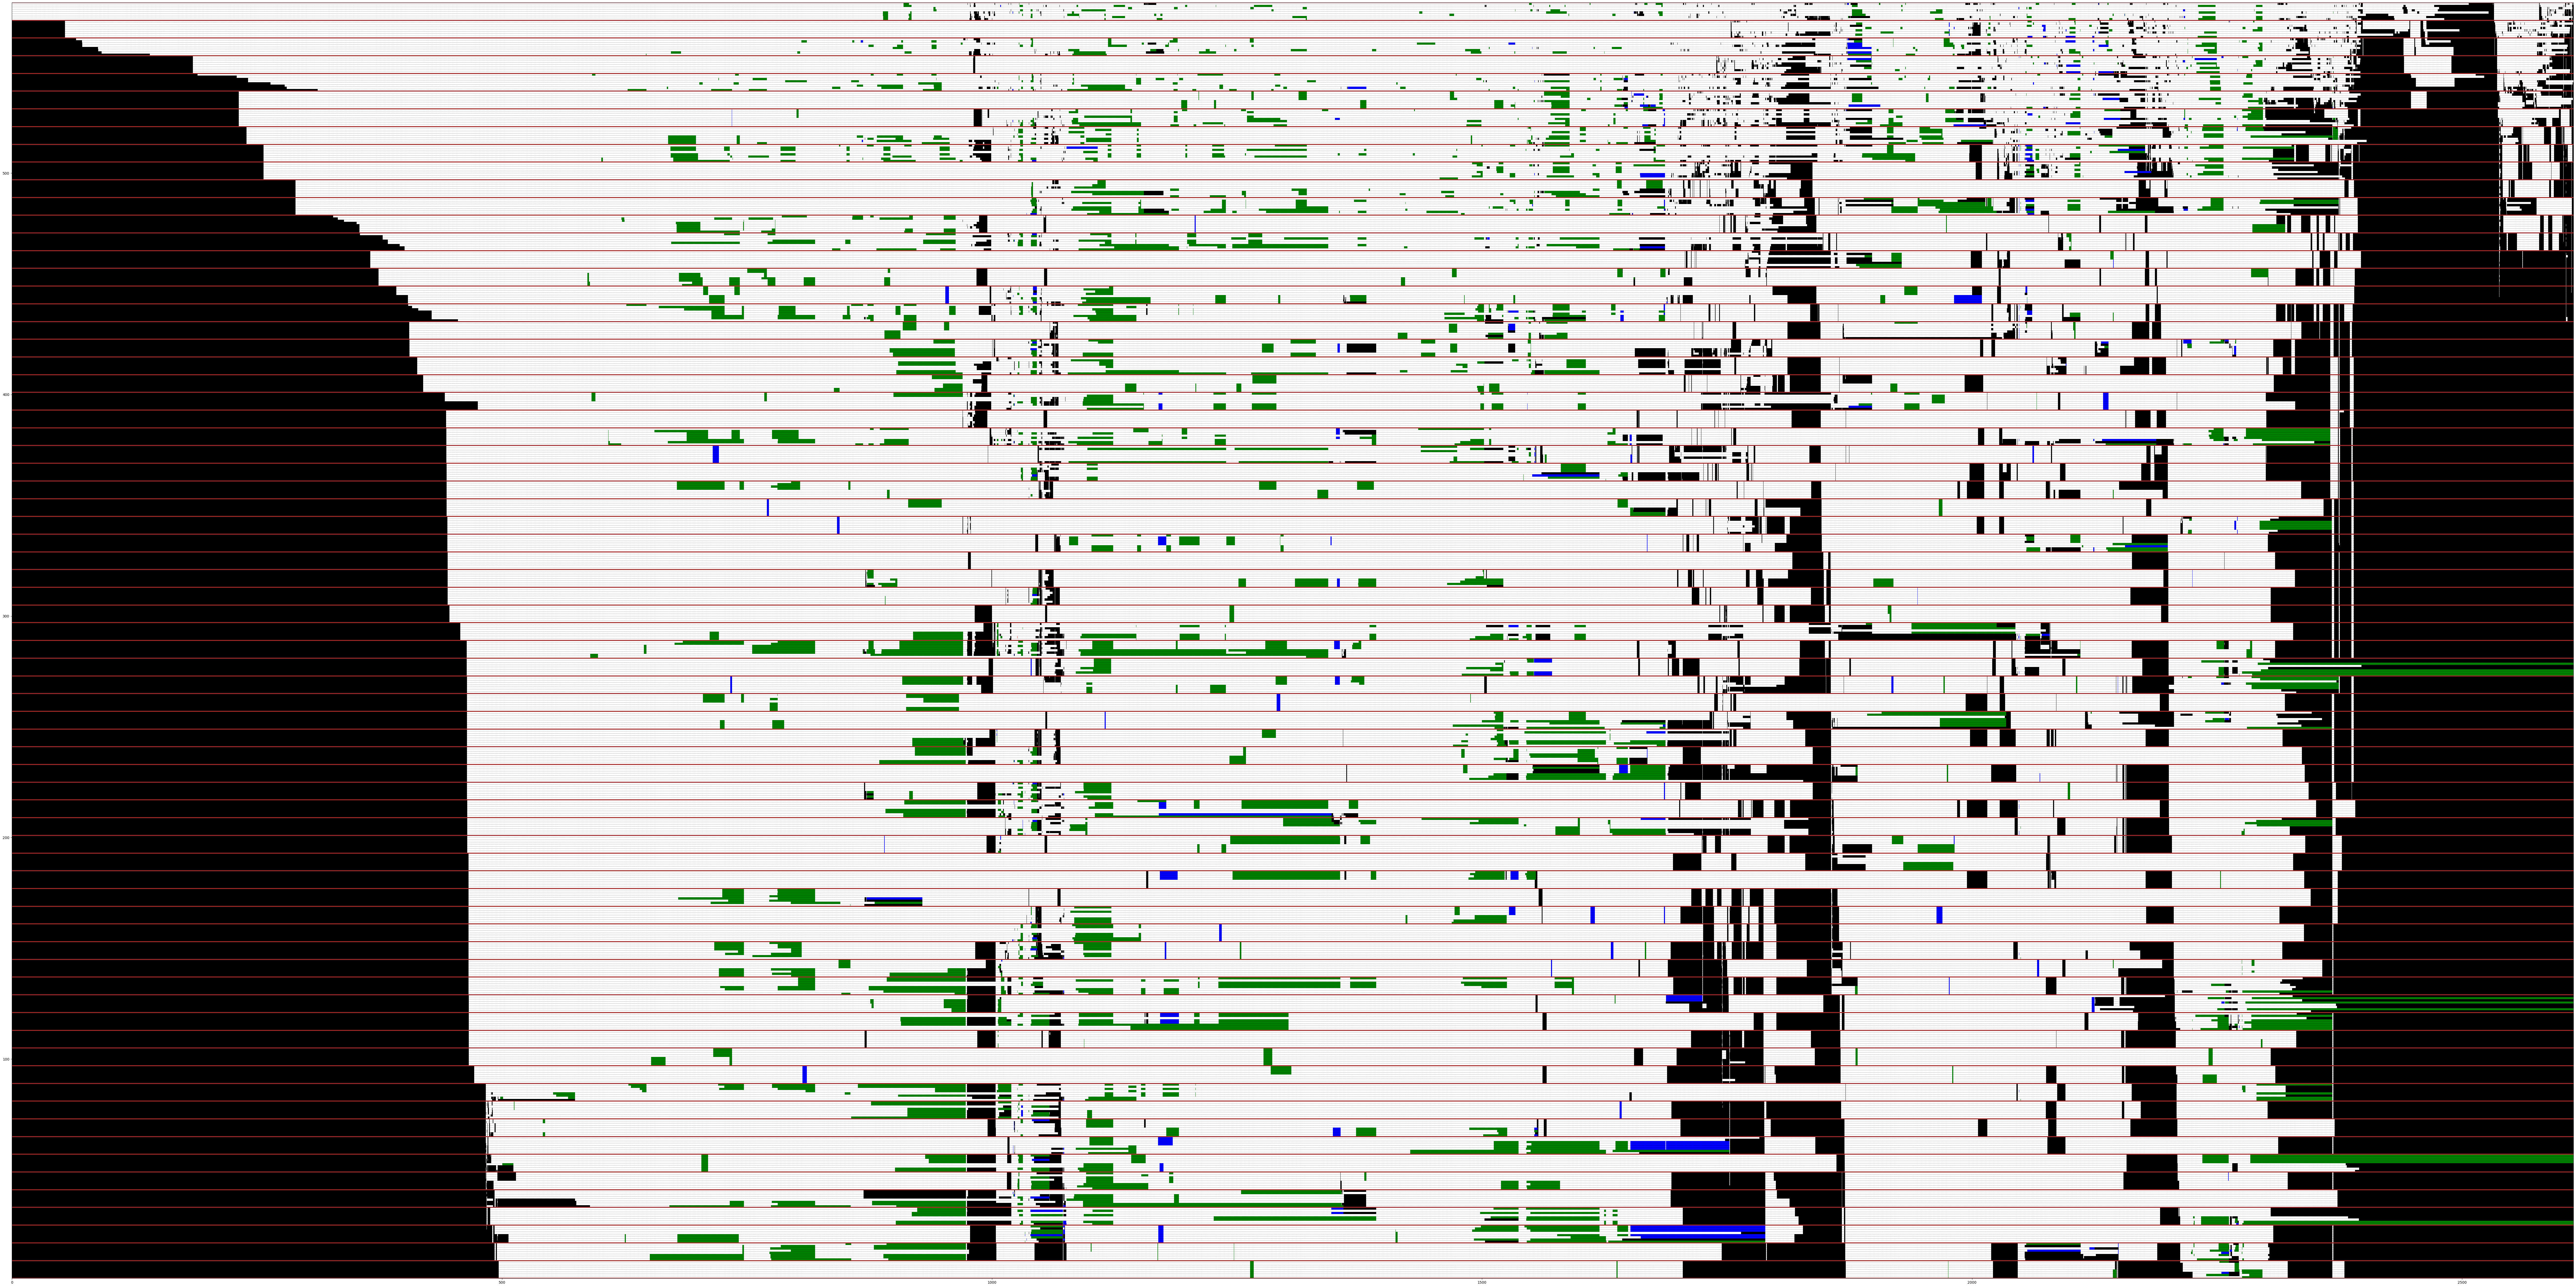

Online Wasted Space: 0.0
Percentage of White Space (to optimize): 1.0
Total Wasted Space: 512140.97944444465


In [65]:
plot_trace_spacetime(asdf[1], 72, asdf[2])

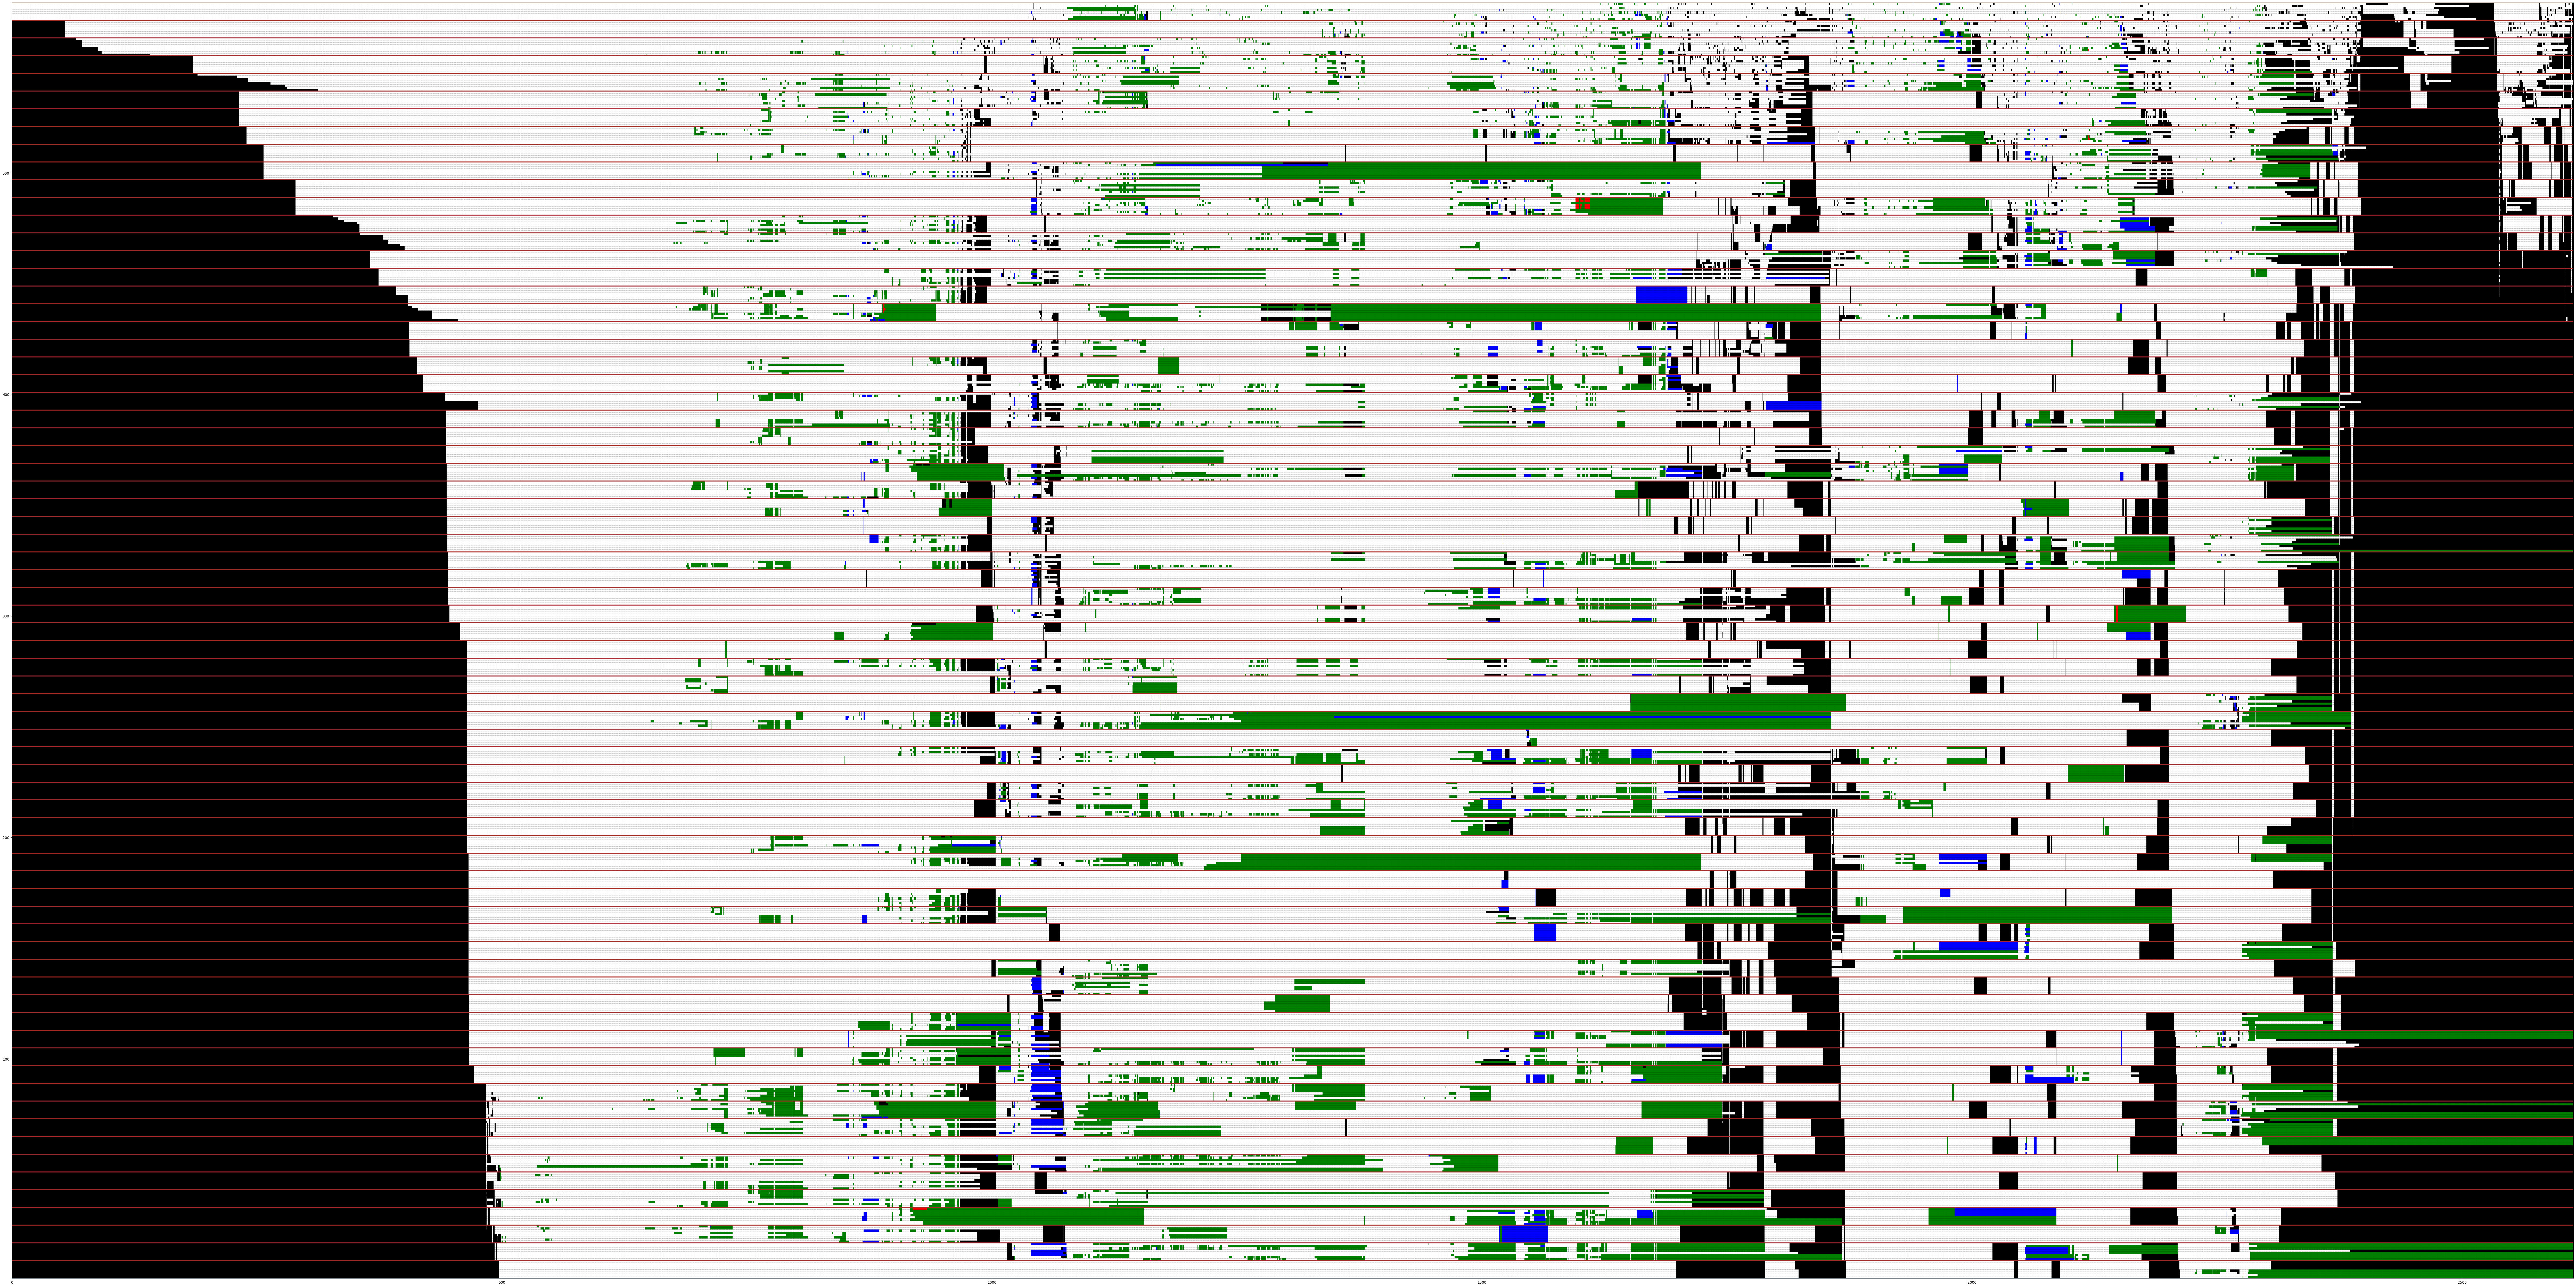

Online Wasted Space: 0.0
Percentage of White Space (to optimize): 1.0
Total Wasted Space: 493967.89972222864


In [66]:
plot_trace_spacetime(asdf1[1], 72, asdf1[2])

In [ ]:
#             if len(snapshots[cur_segment[1]]) ==0:
#                 online_wasted_space += antisegment_width
#                 ax.barh(idx,
#                     width=antisegment_width,
#                     #edgecolor='black',
#                     height=1.0,
#                     left=antisegment[0],
#                     align='edge',
#                     color='red')
#             else:  
#                 ax.barh(idx,
#                     width=antisegment_width,
#                     edgecolor='black',
#                     height=1.0,
#                     left=antisegment[0],
#                     align='edge',
#                     color='black')